In [2]:
# %pip install numpy scipy matplotlib neuron --quiet
!nrnivmodl > null.out

/home/tnieus/mne-python/1.1.0_0/envs/neuron/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


In [3]:
import numpy as np
import pylab as plt
import numpy.random as rnd

In [4]:
import neuron
from neuron import h
from nrnTemplate.cellTemplate import HHcell

# Network with random connectivity

## Define parameters

In [5]:
cells = []
coord = {}
#modPar = {}
RecAll = 2
varDt = False
Pexc = 0.8
num_cells = 40

In [6]:
rndPar = {}
rndPar['weight'] = 0.001
rndPar['start'] = 0
rndPar['fast_invl'] = 25
rndPar['slow_invl'] = 0
rndPar['burst_len'] = 1e10

## Create cells with given parameters

In [7]:
synPar = {}
synPar['weight_e'] = 0.0001
synPar['weight_i'] = 0.0001

for k in range(num_cells):
    coord['x'], coord['y'] = np.random.rand(2)
    #coord = 
    rnd_num = np.random.rand()
    # neuron number k is either excitatory or inhibitory, depending on Pexc
    if rnd_num < Pexc:
        synPar['type'] = 'EXC'
        
    else:
        synPar['type'] = 'INH'    
        
    cells.append(HHcell(synPar=synPar, rndPar=rndPar, RecAll=RecAll, coord=coord, varDt=varDt))

In [8]:
cells[0].pos

{'x': 0.2726043642988286, 'y': 0.35357495818103424}

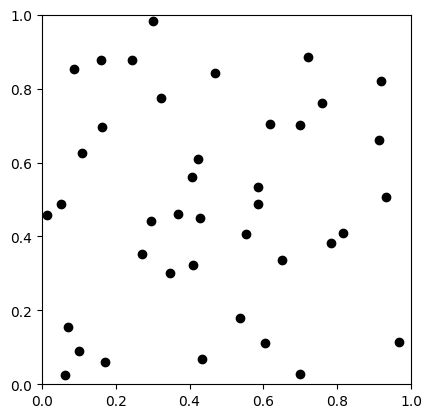

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
for k in range(num_cells):
    plt.plot(cells[k].pos['x'],cells[k].pos['y'],'ko')
plt.xlim(0, 1)
plt.ylim(0, 1)
ax.set_aspect('equal', adjustable='box')    

## Connect cells

In [10]:
Pconn = 0.3
tstop = 1000
adjaceny_matrix = np.zeros((num_cells, num_cells),'int8')

In [11]:
num_connections = 0
for idx_src in range(num_cells):
    Pk = np.random.rand(num_cells)
    Pk[idx_src] = 2 # to avoid self connections
    idx_target = np.where(Pk < Pconn)[0]
    adjaceny_matrix[idx_src, idx_target] = 1
    num_connections += len(idx_target)
    cells[-1].SetSynNoise(rndPar)
    for idx_dst in idx_target:        
        cells[idx_dst].createSyn(cells[idx_src].whatami)
        cells[idx_src].connect_to(dest=cells[idx_dst])
print('number of connections %d ' % num_connections)
n_expected = Pconn*(num_cells**2-num_cells)
print('number of expected connections %d (based on P=%g)' %(n_expected, Pconn) )

number of connections 459 
number of expected connections 468 (based on P=0.3)


In [12]:
print(Pk)

[0.73318983 0.34629305 0.14970395 0.78498766 0.4649553  0.62272009
 0.44776356 0.34522731 0.71755159 0.83168261 0.67081032 0.75847885
 0.49195929 0.70553553 0.88767991 0.57681904 0.56595355 0.30340361
 0.91956765 0.23385815 0.41833569 0.07676923 0.46933115 0.05668672
 0.1333756  0.0354125  0.32697473 0.03684529 0.30476413 0.33687013
 0.52439577 0.41039176 0.95843037 0.7911252  0.10922057 0.54704055
 0.08379071 0.25550605 0.43261007 2.        ]


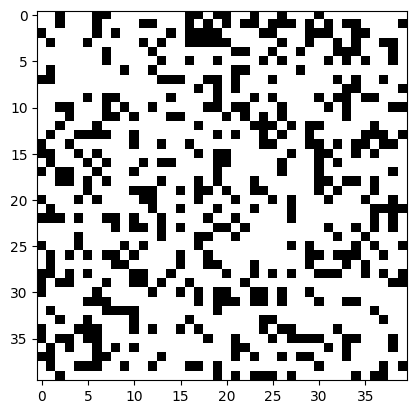

In [13]:
plt.imshow(adjaceny_matrix, plt.cm.binary);

## Check connections work properly

In [14]:
# silence all cells except the first one
rndPar['start'] = tstop
for k in range(1, num_cells):
    cells[k].I.amp = -0.02 # hyperpolarize the membrane
    cells[k].I.delay = 0
    cells[k].I.dur = tstop
    cells[k].SetSynNoise(rndPar)

In [15]:
# run the simulation
h.load_file('stdrun.hoc')
h.tstop = tstop
h.run()

0.0

In [16]:
for k in range(num_cells):
    nspk = len(cells[k].record['spk'])
    if nspk>0:
        print('neuron %d has %d spikes ' % (k, nspk))
print('The other neurons have no spikes!')

neuron 0 has 58 spikes 
The other neurons have no spikes!


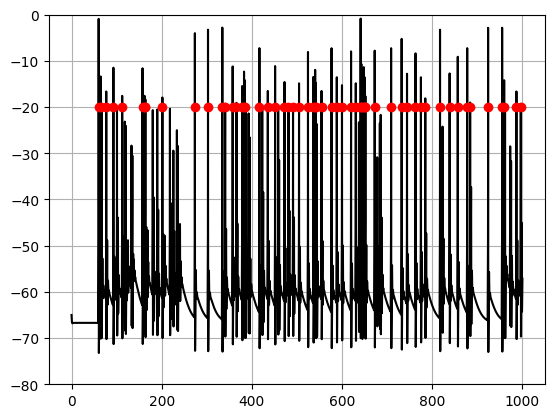

In [17]:
idx_src = 0 #np.random.randint(0,num_cells)
t = np.array(cells[idx_src].record['t'])
vm = np.array(cells[idx_src].record['vm'])
plt.plot(t, vm, 'k-')

tspk = cells[idx_src].record['spk']
plt.plot(tspk, np.repeat(-20, len(tspk)), 'ro')

#plt.xlim(400, 600)
plt.ylim(-80, 0)
plt.grid()

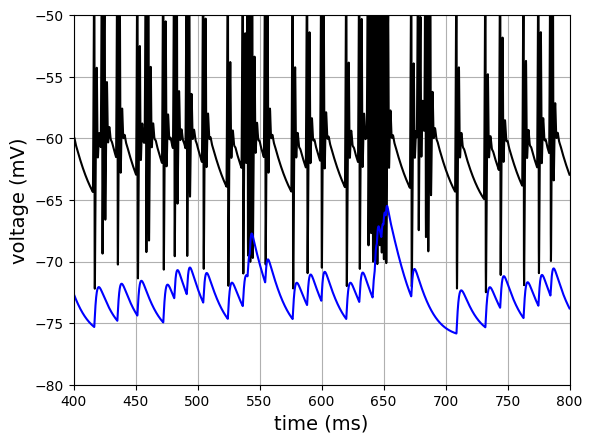

In [18]:
# src
t = np.array(cells[idx_src].record['t'])
vm = np.array(cells[idx_src].record['vm'])
plt.plot(t, vm, 'k-')
tspk = cells[idx_src].record['spk']
plt.plot(tspk, np.repeat(-20, len(tspk)), 'ro')
# 1 dst
idx_src_dst = np.where(adjaceny_matrix[idx_src, :])[0]
idx = np.random.choice(idx_src_dst)
t = np.array(cells[idx].record['t'])
vm = np.array(cells[idx].record['vm'])
plt.plot(t, vm, 'b-')
# resize and decorate plot
plt.xlim(400, 800)
plt.ylim(-80, -50)
plt.xlabel('time (ms)',fontsize=14)
plt.ylabel('voltage (mV)',fontsize=14)
plt.grid();

In [19]:
print(t[1]-t[0])

0.025


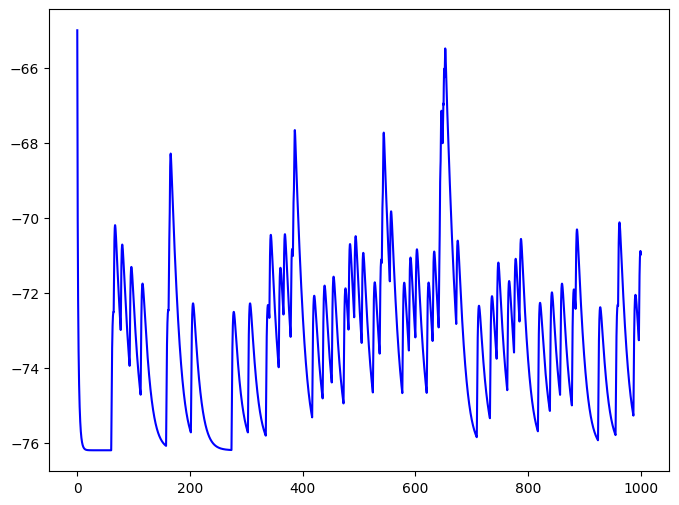

In [20]:
plt.figure(figsize=(8,6))
plt.plot(t, vm, 'b-')
#plt.ylim(-77,-73.5)
dout = {}
dout['t'] = t
dout['vm'] = vm
d = np.zeros((len(t), 2))
d[:, 0] = t
d[:, 1] = vm

np.savetxt('dout.txt', d)

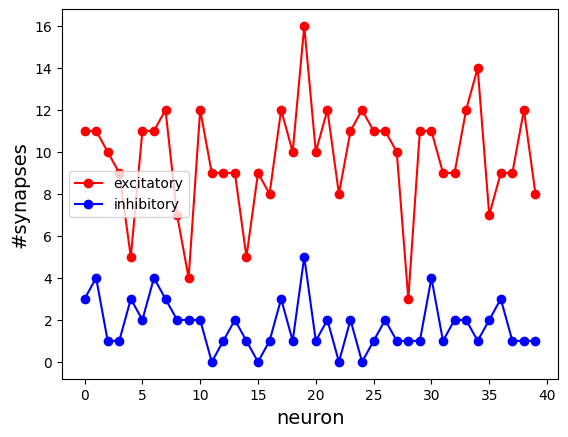

In [21]:
nexc_lst = []
ninh_lst = []
for k in range(num_cells):
    nexc_lst.append(len(cells[k].ExcSynList))
    ninh_lst.append(len(cells[k].InhSynList))
    #print('cell %d with incoming excitatory (%d) and inhibitory (%d) synapses.' %(k, nexc, ninh))
plt.plot(nexc_lst,'ro-',label='excitatory')
plt.plot(ninh_lst,'bo-',label='inhibitory')
plt.xlabel('neuron', fontsize=14)
plt.ylabel('#synapses', fontsize=14)
plt.legend(loc=6)